In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload
from time import time
import pickle
from copy import deepcopy

import numpy as np
import scipy as sc
import pandas as pd
import torch
print(torch.cuda.is_available())
from statsmodels.stats.weightstats import _zstat_generic

import models
import dre
import rna
from calibrate import rectified_p_value
import vae
import designers
import editdistance

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('whitegrid')

PATH = '/homefs/home/wongfanc/density-ratio-estimation'

True


2024-04-09 01:55:07.942068: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 01:55:07.942104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 01:55:07.943321: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-09 01:55:07.950007: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 01:55:09.625080: W tensorflow/comp

# test out DRE

In [3]:
# generate and save calibration data
reload(rna)
noise_sd = 0.02
p_mut = 4 / 50

landscape = rna.RNABinding(noise_sd=noise_sd)
calseqs_n, ycal_n = landscape.get_training_data(5000, p_mut)

fname = os.path.join(PATH, 'rna-results', 'calibration-pm{:.2f}-nsd{:.2f}-040524.npz'.format(p_mut, noise_sd))
np.savez(fname, calseqs_n=calseqs_n, ycal_n=ycal_n)

Generating 5000 labeled sequences...
Done. (33 s)


In [2]:
# load calibration data
noise_sd = 0.02
p_mut = 4 / 50
fname = os.path.join(PATH, 'rna-results', 'calibration-pm{:.2f}-nsd{:.2f}-040524.npz'.format(p_mut, noise_sd))
d = np.load(fname)
calseqs_n = list(d['calseqs_n'])
ycal_n = d['ycal_n']

In [3]:
# load training data (can train MDRE using both train and calibration)
model_and_data_path = '/homefs/home/wongfanc/density-ratio-estimation/rna-models'
model_and_data_fname_no_ftype = 'nsd0.02-040324'
n_hidden = 100
n_filters = 32

# load training data
data_fname = os.path.join(model_and_data_path, 'traindata-' + model_and_data_fname_no_ftype + '.npz')
d = np.load(data_fname)
trainseq_n = list(d['trainseq_n'])
ytrain_n = d['ytrain_n']
print(f'Loaded {ytrain_n.size} training points from {data_fname}.\n')

Loaded 5000 training points from /homefs/home/wongfanc/density-ratio-estimation/rna-models/traindata-nsd0.02-040324.npz.



Design distributions:
  dbas-ridge
  train


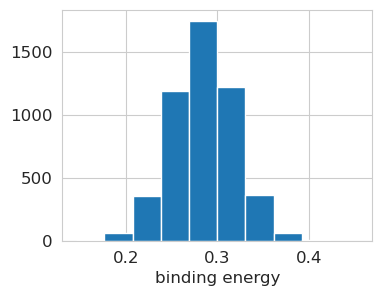

In [5]:
# load design distributions
reload(rna)
noise_sd = 0.02
n_hidden = 100
# p_mut = 4 / 50

# load all
design_pkl_fname = os.path.join(
    PATH, 'rna-results', 'designs-nsd{}-040324.pkl'.format(noise_sd)
)
with open(design_pkl_fname, 'rb') as f:
    designname2data = pickle.load(f)
    
# select specific ones and add train
designname2data = {
    name: (data[0], data[1], data[2]) for name, data in designname2data.items()
    if 'dbas' in name and 'ridge' in name
}
designname2data['train'] = (calseqs_n + trainseq_n, np.hstack([ycal_n, ytrain_n]), None)
print('Design distributions:')
for name in designname2data.keys():
    print(f'  {name}')
    
plt.figure(figsize=(4, 3))
plt.hist(ycal_n)
plt.xlabel('binding energy');

/tmp/ipykernel_73455/2662825632.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('Set1')


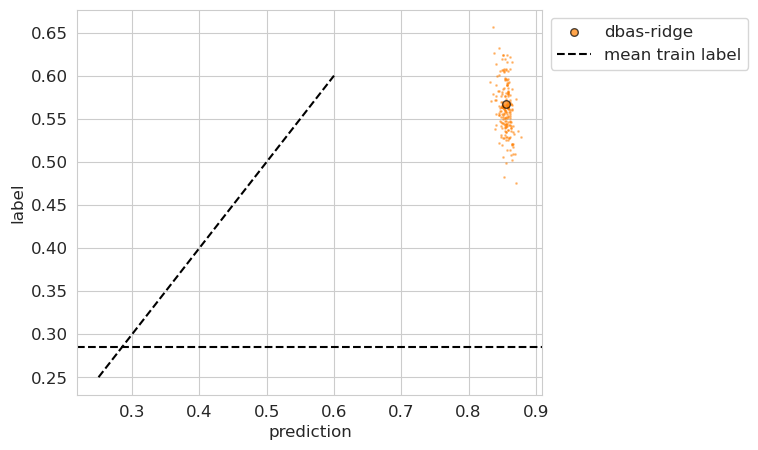

In [6]:
cmap = mpl.cm.get_cmap('Set1')
n_to_plot = 200
name2marker = {'ridge': 'o', 'ff': 's', 'cnn': 'D'} 
algnames = ['adalead', 'biswas', 'cbas', 'dbas', 'pex']

def get_marker(designname):
    for name, marker in name2marker.items():
        if name in designname:
            return marker

def get_color(designname):
    for i, name in enumerate(algnames):
        if name in designname:
            return cmap(i + 1)


xy_lim = [0.25, 0.6]
plt.figure(figsize=(6, 5))

for i, data in enumerate(designname2data.items()):
    name, (seq_n, y_n, pred_n) = data
    # if 'adalead' in name:
    color = get_color(name)
    marker = get_marker(name)

    if name != 'train':
        idx = np.random.choice(y_n.size, n_to_plot)
        plt.scatter(pred_n[idx], y_n[idx], alpha=0.4, s=1, marker=marker, color=color)
        
for i, data in enumerate(designname2data.items()):
    name, (seq_n, y_n, pred_n) = data
    # if 'adalead' in name:
    color = get_color(name)
    marker = get_marker(name)

    if name != 'train':
        plt.scatter(
            np.mean(pred_n), np.mean(y_n), s=30, alpha=0.7,
            edgecolor='k', marker=marker, color=color, label=name
    )

plt.axhline(np.mean(designname2data['train'][1]), linestyle='--', color='k', label='mean train label')
        
plt.plot(xy_lim, xy_lim, linestyle='--', color='k', )
plt.legend(bbox_to_anchor=(1, 1));
plt.xlabel('prediction')
plt.ylabel('label');

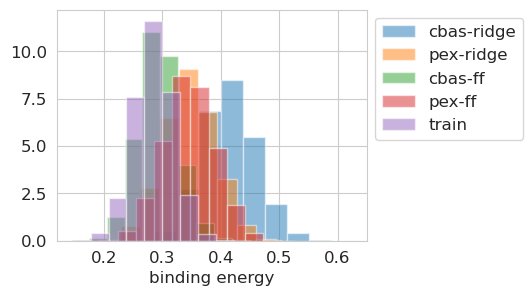

In [6]:
plt.figure(figsize=(4, 3))
for name, (seq_n, y_n, pred_n) in designname2data.items():
    plt.hist(y_n, alpha=0.5, label=name, density=True)
    
plt.xlabel('binding energy');
plt.legend(bbox_to_anchor=(1, 1));

One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 155.80it/s]


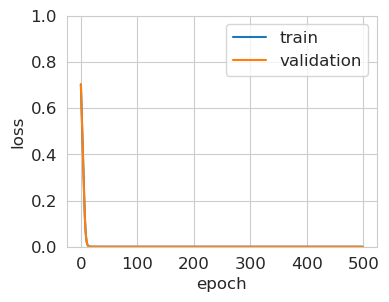

In [7]:
# fit MDRE
reload(dre)
n_hidden = 256
n_epoch = 500
lr = 1e-3

device = torch.device('cuda')

mdre = dre.MultinomialLogisticRegresssionDensityRatioEstimator(
    50,
    len(designname2data.keys()),
    n_hidden,
    device=device
)
loss_df = mdre.fit(
    designname2data,
    n_epoch,
    lr=lr
)

plt.figure(figsize=(4, 3))
plt.plot(loss_df['train_loss'], label='train')
plt.plot(loss_df['val_loss'], label='validation')
plt.legend() 
plt.xlabel('epoch');
plt.ylabel('loss');
plt.ylim([0, 1]);

In [4]:
# load models to get predictions for calibration data
model_and_data_path = '/homefs/home/wongfanc/density-ratio-estimation/rna-models'
model_and_data_fname_no_ftype = 'nsd0.02-040324'
n_hidden = 100
n_filters = 32

# train ridge regression, load trained FF and CNN models
ridge = ridge = models.RidgeRegressor(seq_len=50, alphabet=rna.RNA_NUCLEOTIDES)
ridge.fit(trainseq_n, ytrain_n)

ff_fname = os.path.join(model_and_data_path, 'ff-' + model_and_data_fname_no_ftype + '.pt')
ff = models.FeedForward(50, rna.RNA_NUCLEOTIDES, n_hidden)
ff.load(ff_fname)

cnn_fname = os.path.join(model_and_data_path, 'cnn-' + model_and_data_fname_no_ftype + '.pt')
cnn = models.CNN(50, rna.RNA_NUCLEOTIDES, n_filters, n_hidden)
cnn.load(cnn_fname)

name2model = {
    'ridge': ridge,
    'ff': ff,
    'cnn': cnn
}

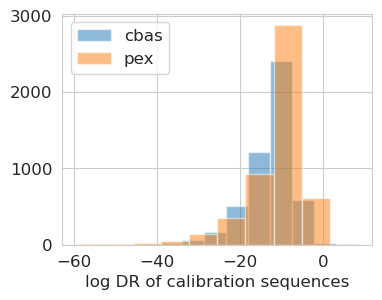

In [29]:
plt.figure(figsize=(4, 3))
plt.hist(np.log(designname2dr['cbas-ridge']), alpha=0.5, label='cbas');
# plt.hist(np.log(designname2dr['dbas-ridge']), alpha=0.5, label='dbas');
plt.hist(np.log(designname2dr['pex-ridge']), alpha=0.5, label='pex');
plt.xlabel('log DR of calibration sequences');
plt.legend();

In [9]:
# point estimates
alpha = 0.1
target_values = np.arange(0.34, 0.51, 0.01)

# get DRs for each design distribution
designname2dr = mdre.get_dr(calseqs_n, self_normalize=True)
imp_target2name = {val: [] for val in target_values}
pp_target2name = {val: [] for val in target_values}
pointest_mx3 = np.zeros([len(designname2data), 3])

for i, data in enumerate(designname2data.items()):
    
    design_name, (designseq_n, ydesign_n, preddesign_n) = data
    for model_name in name2model.keys():
        if model_name in design_name:
            model = name2model[model_name]
            print('using {} for {}'.format(model_name, design_name))
    
    if design_name != 'train':
        print(design_name)
        
        imputed_mean = np.mean(preddesign_n)
        imputed_se = np.std(preddesign_n) / np.sqrt(preddesign_n.size)
        
        # caldr_n = designname2dr[design_name]
        caldr_n = np.random.rand(len(calseqs_n))
        caldr_n = caldr_n * len(calseqs_n) / caldr_n.sum()
        predcal_n = model.predict(calseqs_n)
        rect_n = caldr_n * (ycal_n - predcal_n)
        rectifier_mean = np.mean(rect_n)
        rectifier_se = np.std(rect_n) / np.sqrt(rect_n.size)
        pointest_mx3[i] = np.mean(ydesign_n), np.mean(preddesign_n) + rectifier_mean, np.mean(preddesign_n)

        print('{:.3f} {:.3f} {:.3f}'.format(
            np.mean(ydesign_n), np.mean(preddesign_n), np.mean(preddesign_n) + rectifier_mean
        ))
        
        for target_val in target_values:

            # run imputation hypothesis test
            imp_pval = _zstat_generic(
                imputed_mean,
                0,
                imputed_se,
                alternative='larger',
                diff=target_val
            )[1]

            # run prediction-powered hypothesis test
            pp_pval = rectified_p_value(
                rectifier_mean,
                rectifier_se,
                imputed_mean,
                imputed_se,
                null=target_val,
                alternative='larger'
            )

            # Bonferroni correction
            if imp_pval < alpha / len(designname2data):
                imp_target2name[target_val].append(design_name)
                
            if pp_pval < alpha / len(designname2data):
                pp_target2name[target_val].append(design_name)
    else:
        train_idx = i
pointest_mx3 = np.delete(pointest_mx3, train_idx, axis=0)

using ridge for dbas-ridge
dbas-ridge
0.568 0.855 0.854


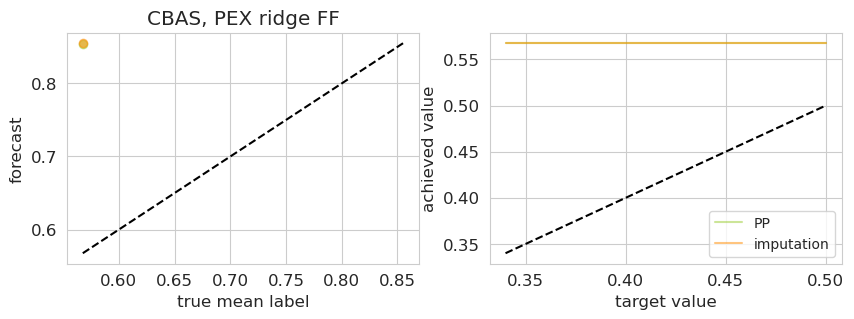

In [10]:
# run preliminary selection experiments and plot
title = 'CBAS, PEX ridge FF'

impach_t = []
ppach_t = []
xy_lim = [np.min(target_values), np.max(target_values)]

for val in target_values:
    names = imp_target2name[val]
    imp_truemeans = [np.mean(designname2data[name][1]) for name in names]
    if len(imp_truemeans):
        impach_t.append(np.min(imp_truemeans))
    else:
        impach_t.append(np.nan)
    
    names = pp_target2name[val]
    pp_truemeans = [np.mean(designname2data[name][1]) for name in names]
    if len(pp_truemeans):
        ppach_t.append(np.min(pp_truemeans))
    else:
        ppach_t.append(np.nan)

plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.scatter(pointest_mx3[:, 0], pointest_mx3[:, 1], label='PP', c='yellowgreen', alpha=0.5)
plt.scatter(pointest_mx3[:, 0], pointest_mx3[:, 2], label='imputation', c='darkorange', alpha=0.5) 
plt.plot([np.min(pointest_mx3), np.max(pointest_mx3)], [np.min(pointest_mx3), np.max(pointest_mx3)], '--k');
plt.xlabel('true mean label');
plt.ylabel('forecast');
plt.title(title);

plt.subplot(122)
plt.plot(target_values, ppach_t, label='PP', c='yellowgreen', alpha=0.5)
plt.plot(target_values, impach_t, label='imputation', c='darkorange', alpha=0.5)
plt.plot(xy_lim, xy_lim, '--k');
plt.xlabel('target value');
plt.ylabel('achieved value');
plt.legend(fontsize=10);

# check out DbAS/CbAS hyperparameters again

In [19]:
reload(vae)
reload(designers)

latent_dim = 10
n_hidden = 20
weight_type = 'dbas'
device = 'cpu'
model_name = 'ridge'

model = name2model[model_name]
cbas = designers.CbAS(
    model,
    trainseq_n,
    latent_dim=latent_dim,
    n_hidden=n_hidden,
    weight_type=weight_type,
    device=device
)

Fitting training distribution:
One-hot encoded sequences to shape = (5000, 50, 4) (0 sec)
4500 training data points, 500 validation data points.
Epoch 0. Train loss: 21.6568, KL: 0.8063, CE: 20.8505. Val loss: 69.5507, KL: 0.2811, CE: 69.2696. (1 s)
Epoch 1. Train loss: 14.8439, KL: 0.0144, CE: 14.8295. Val loss: 15.2565, KL: 0.0174, CE: 15.2392. (2 s)
Epoch 2. Train loss: 14.7007, KL: 0.0298, CE: 14.6709. Val loss: 15.0425, KL: 0.0162, CE: 15.0263. (1 s)
Epoch 3. Train loss: 14.6663, KL: 0.0495, CE: 14.6168. Val loss: 14.9703, KL: 0.0448, CE: 14.9255. (1 s)
Epoch 4. Train loss: 14.6327, KL: 0.0419, CE: 14.5908. Val loss: 14.9607, KL: 0.0427, CE: 14.9180. (1 s)


In [7]:
# try different quantiles
n_design = 50000
quantiles = np.arange(0.15, 0.91, 0.1)
noise_sd = 0.02

landscape = rna.RNABinding(noise_sd=noise_sd)
predtrain_n = model.predict(trainseq_n)
disttrain_n = np.array([editdistance.eval(rna.RNABinding.SEEDS[3], s) for s in trainseq_n])
q2preddist = {}
designname2data = {}

for q in quantiles:
    design_n = cbas.design_sequences(
        n_design,
        quantile=q
    )

    preddesign_n = model.predict(design_n)
    ydesign_n = landscape.get_fitness(design_n)
    
    designname2data['dbas{:.2f}-{}'.format(q, model_name)] = (design_n, ydesign_n, preddesign_n)
    
    distdesign_n = np.array([editdistance.eval(rna.RNABinding.SEEDS[3], s) for s in design_n])
    q2preddist[q] = (preddesign_n, distdesign_n)
    print('q = {:.2f}, mean prediction {:.3f}, mean label {:.3f}, mean distance {:.3f}'.format(
        q, np.mean(preddesign_n), np.mean(ydesign_n), np.mean(distdesign_n)
    ))

Fitting design distribution with quantile hyperparameter = 0.15:
Iter 0. Mean, SD, max prediction: 0.285, 0.025, 0.385. 1000 valid samples for threshold 0.261. (4 s)
Iter 1. Mean, SD, max prediction: 0.293, 0.022, 0.362. 1000 valid samples for threshold 0.271. (8 s)
Iter 2. Mean, SD, max prediction: 0.296, 0.022, 0.388. 1000 valid samples for threshold 0.275. (12 s)
Iter 3. Mean, SD, max prediction: 0.300, 0.022, 0.385. 1000 valid samples for threshold 0.280. (17 s)
Iter 4. Mean, SD, max prediction: 0.305, 0.024, 0.408. 1000 valid samples for threshold 0.284. (21 s)
Iter 5. Mean, SD, max prediction: 0.310, 0.025, 0.405. 1000 valid samples for threshold 0.287. (25 s)
Iter 6. Mean, SD, max prediction: 0.316, 0.026, 0.414. 1000 valid samples for threshold 0.288. (30 s)
Iter 7. Mean, SD, max prediction: 0.324, 0.029, 0.440. 1000 valid samples for threshold 0.294. (34 s)
Iter 8. Mean, SD, max prediction: 0.332, 0.030, 0.447. 1000 valid samples for threshold 0.302. (38 s)
Iter 9. Mean, SD, m

Iter 16. Mean, SD, max prediction: 0.638, 0.042, 0.760. 991 valid samples for threshold 0.635. (74 s)
Iter 17. Mean, SD, max prediction: 0.664, 0.040, 0.768. 992 valid samples for threshold 0.660. (78 s)
Iter 18. Mean, SD, max prediction: 0.689, 0.038, 0.797. 995 valid samples for threshold 0.685. (82 s)
Iter 19. Mean, SD, max prediction: 0.711, 0.035, 0.811. 999 valid samples for threshold 0.708. (87 s)
q = 0.5, mean prediction 0.731, mean label 0.579, mean distance 22.170
Fitting design distribution with quantile hyperparameter = 0.55:
Iter 0. Mean, SD, max prediction: 0.286, 0.024, 0.386. 999 valid samples for threshold 0.287. (4 s)
Iter 1. Mean, SD, max prediction: 0.297, 0.024, 0.387. 1000 valid samples for threshold 0.297. (8 s)
Iter 2. Mean, SD, max prediction: 0.312, 0.027, 0.415. 1000 valid samples for threshold 0.313. (13 s)
Iter 3. Mean, SD, max prediction: 0.326, 0.030, 0.436. 1000 valid samples for threshold 0.328. (17 s)
Iter 4. Mean, SD, max prediction: 0.345, 0.033, 0.4

Iter 11. Mean, SD, max prediction: 0.753, 0.030, 0.832. 990 valid samples for threshold 0.784. (51 s)
Iter 12. Mean, SD, max prediction: 0.784, 0.026, 0.851. 995 valid samples for threshold 0.811. (55 s)
Iter 13. Mean, SD, max prediction: 0.807, 0.023, 0.862. 1000 valid samples for threshold 0.831. (60 s)
Iter 14. Mean, SD, max prediction: 0.825, 0.018, 0.867. 1000 valid samples for threshold 0.843. (64 s)
Iter 15. Mean, SD, max prediction: 0.837, 0.014, 0.874. 1000 valid samples for threshold 0.852. (68 s)
Iter 16. Mean, SD, max prediction: 0.846, 0.011, 0.872. 1000 valid samples for threshold 0.856. (73 s)
Iter 17. Mean, SD, max prediction: 0.851, 0.010, 0.879. 1000 valid samples for threshold 0.861. (77 s)
Iter 18. Mean, SD, max prediction: 0.855, 0.009, 0.879. 1000 valid samples for threshold 0.863. (81 s)
Iter 19. Mean, SD, max prediction: 0.858, 0.008, 0.881. 1000 valid samples for threshold 0.866. (86 s)
q = 0.9, mean prediction 0.860, mean label 0.583, mean distance 26.267


In [8]:
designname2data['train'] = (calseqs_n + trainseq_n, np.hstack([ycal_n, ytrain_n]), None)

In [9]:
design_pkl_fname = os.path.join(
    PATH, 'rna-results', 'dbas-designs-040824-2.pkl'.format(noise_sd)
)
with open(design_pkl_fname, 'wb') as f:
    pickle.dump(designname2data, f)

In [12]:
# stitch together results from different quantiles
design_pkl_fname = os.path.join(PATH, 'rna-results', 'dbas-designs-040824.pkl')
with open(design_pkl_fname, 'rb') as f:
    designname2data = pickle.load(f)

design_pkl_fname2 = os.path.join(PATH, 'rna-results', 'dbas-designs-040824-2.pkl')
with open(design_pkl_fname2, 'rb') as f2:
    designname2data2 = pickle.load(f2) 

designname2data.update(designname2data2)

designname2data = {
    name: data for name, data in designname2data.items()
    if '0.1-' in name or '0.2-' in name or '0.3-' in name or '0.4-' in name or '0.5-' in name or 'train' in name
}
print(designname2data.keys())

dict_keys(['dbas0.1-ridge', 'dbas0.2-ridge', 'dbas0.3-ridge', 'dbas0.4-ridge', 'dbas0.5-ridge', 'train'])


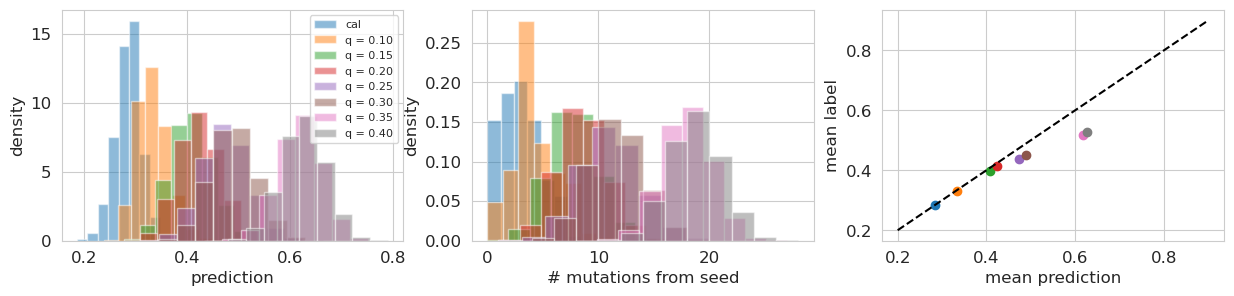

In [23]:
# plot different quantile design distributions
plt.figure(figsize=(15, 3))

predcal_n = name2model['ridge'].predict(calseqs_n)
distcal_n = np.array([editdistance.eval(rna.RNABinding.SEEDS[3], s) for s in calseqs_n])

plt.subplot(131)
plt.hist(predcal_n, alpha=0.5, label='cal', density=True)
plt.xlabel('prediction');
plt.ylabel('density');

plt.subplot(132)
plt.hist(distcal_n, alpha=0.5, label='cal', density=True)
plt.xlabel('# mutations from seed');
plt.ylabel('density');

plt.subplot(133)
plt.scatter(np.mean(predcal_n), np.mean(ycal_n))
plt.plot([0.2, 0.9], [0.2, 0.9], '--k');
plt.xlabel('mean prediction'); plt.ylabel('mean label');

for q in np.arange(0.1, 0.4, 0.05):
    # preddesign_n, distdesign_n = q2preddist[q]
    
    q = round(q, 2)
    designseq_n, ydesign_n, preddesign_n = designname2data['dbas{}-ridge'.format(q)]
    distdesign_n = np.array([editdistance.eval(rna.RNABinding.SEEDS[3], s) for s in designseq_n])

    plt.subplot(131)
    plt.hist(preddesign_n, alpha=0.5, label='q = {:.2f}'.format(q), density=True)

    plt.subplot(132)
    plt.hist(distdesign_n, alpha=0.5, density=True)
    
    plt.subplot(133)
    plt.scatter(np.mean(preddesign_n), np.mean(ydesign_n))
    
plt.subplot(131)
plt.legend(fontsize=8);

One-hot-encoding all 11 categories of sequences...
  Done. (7 s)


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:23<00:00, 21.09it/s]


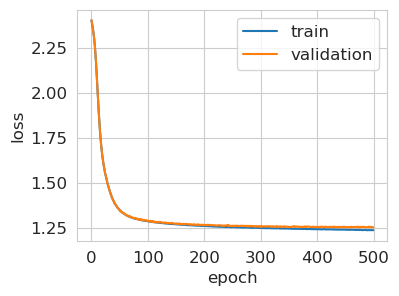

In [30]:
# fit MDRE
reload(dre)
n_hidden = 256
n_epoch = 500
lr = 1e-3

device = torch.device('cuda')

mdre = dre.MultinomialLogisticRegresssionDensityRatioEstimator(
    50,
    len(designname2data.keys()),
    n_hidden,
    device=device
)
loss_df = mdre.fit(
    designname2data,
    n_epoch,
    lr=lr
)

plt.figure(figsize=(4, 3))
plt.plot(loss_df['train_loss'], label='train')
plt.plot(loss_df['val_loss'], label='validation')
plt.legend() 
plt.xlabel('epoch');
plt.ylabel('loss');
# plt.ylim([0, 1]);

In [14]:
# point estimates
alpha = 0.1
target_values = np.arange(0.3, 0.91, 0.01)

# get DRs for each design distribution
designname2dr = mdre.get_dr(calseqs_n, self_normalize=True)
imp_target2name = {val: [] for val in target_values}
pp_target2name = {val: [] for val in target_values}
pointest_mx3 = np.zeros([len(designname2data), 3])

for i, data in enumerate(designname2data.items()):
    
    design_name, (designseq_n, ydesign_n, preddesign_n) = data
    for model_name in name2model.keys():
        if model_name in design_name:
            model = name2model[model_name]
            print('using {} for {}'.format(model_name, design_name))
    
    if design_name != 'train':
        print(design_name)
        
        imputed_mean = np.mean(preddesign_n)
        imputed_se = np.std(preddesign_n) / np.sqrt(preddesign_n.size)
        
        caldr_n = designname2dr[design_name]
        predcal_n = model.predict(calseqs_n)
        rect_n = caldr_n * (ycal_n - predcal_n)
        rectifier_mean = np.mean(rect_n)
        rectifier_se = np.std(rect_n) / np.sqrt(rect_n.size)
        pointest_mx3[i] = np.mean(ydesign_n), np.mean(preddesign_n) + rectifier_mean, np.mean(preddesign_n)

        print('{:.3f} {:.3f} {:.3f}'.format(
            np.mean(ydesign_n), np.mean(preddesign_n), np.mean(preddesign_n) + rectifier_mean
        ))
        
        for target_val in target_values:

            # run imputation hypothesis test
            imp_pval = _zstat_generic(
                imputed_mean,
                0,
                imputed_se,
                alternative='larger',
                diff=target_val
            )[1]

            # run prediction-powered hypothesis test
            pp_pval = rectified_p_value(
                rectifier_mean,
                rectifier_se,
                imputed_mean,
                imputed_se,
                null=target_val,
                alternative='larger'
            )

            # Bonferroni correction
            if imp_pval < alpha / len(designname2data):
                imp_target2name[target_val].append(design_name)
                
            if pp_pval < alpha / len(designname2data):
                pp_target2name[target_val].append(design_name)
    else:
        train_idx = i
pointest_mx3 = np.delete(pointest_mx3, train_idx, axis=0)

using ridge for dbas0.1-ridge
dbas0.1-ridge
0.332 0.333 0.336
using ridge for dbas0.2-ridge
dbas0.2-ridge
0.413 0.423 0.419
using ridge for dbas0.3-ridge
dbas0.3-ridge
0.449 0.489 0.486
using ridge for dbas0.4-ridge
dbas0.4-ridge
0.528 0.626 0.613
using ridge for dbas0.5-ridge
dbas0.5-ridge
0.566 0.715 0.699


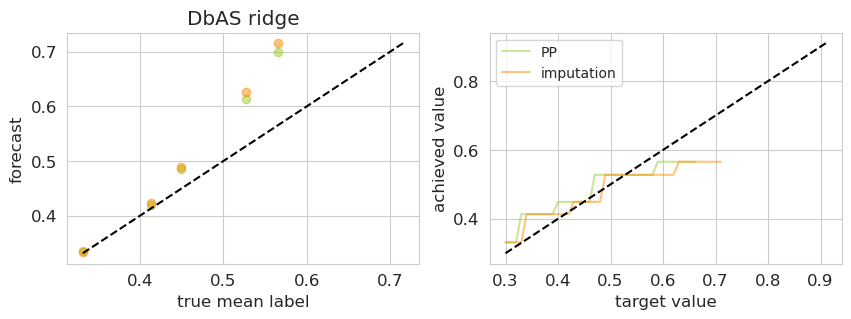

In [15]:
# run preliminary selection experiments and plot
title = 'DbAS ridge'

impach_t = []
ppach_t = []
xy_lim = [np.min(target_values), np.max(target_values)]

for val in target_values:
    names = imp_target2name[val]
    imp_truemeans = [np.mean(designname2data[name][1]) for name in names]
    if len(imp_truemeans):
        impach_t.append(np.min(imp_truemeans))
    else:
        impach_t.append(np.nan)
    
    names = pp_target2name[val]
    pp_truemeans = [np.mean(designname2data[name][1]) for name in names]
    if len(pp_truemeans):
        ppach_t.append(np.min(pp_truemeans))
    else:
        ppach_t.append(np.nan)

plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.scatter(pointest_mx3[:, 0], pointest_mx3[:, 1], label='PP', c='yellowgreen', alpha=0.5)
plt.scatter(pointest_mx3[:, 0], pointest_mx3[:, 2], label='imputation', c='darkorange', alpha=0.5) 
plt.plot([np.min(pointest_mx3), np.max(pointest_mx3)], [np.min(pointest_mx3), np.max(pointest_mx3)], '--k');
plt.xlabel('true mean label');
plt.ylabel('forecast');
plt.title(title);

plt.subplot(122)
plt.plot(target_values, ppach_t, label='PP', c='yellowgreen', alpha=0.5)
plt.plot(target_values, impach_t, label='imputation', c='darkorange', alpha=0.5)
plt.plot(xy_lim, xy_lim, '--k');
plt.xlabel('target value');
plt.ylabel('achieved value');
plt.legend(fontsize=10);